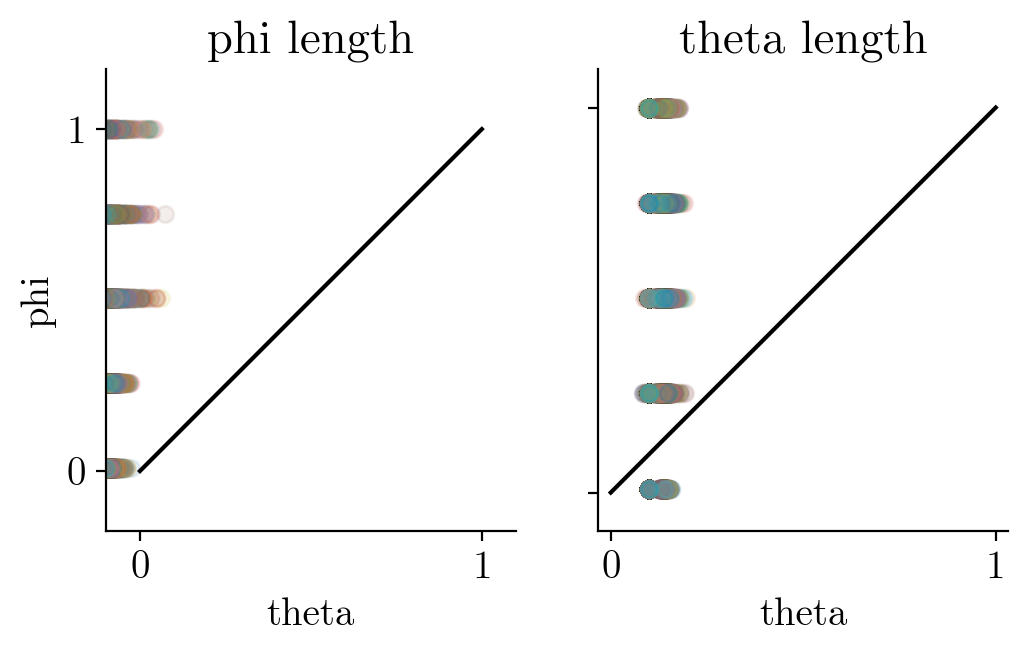

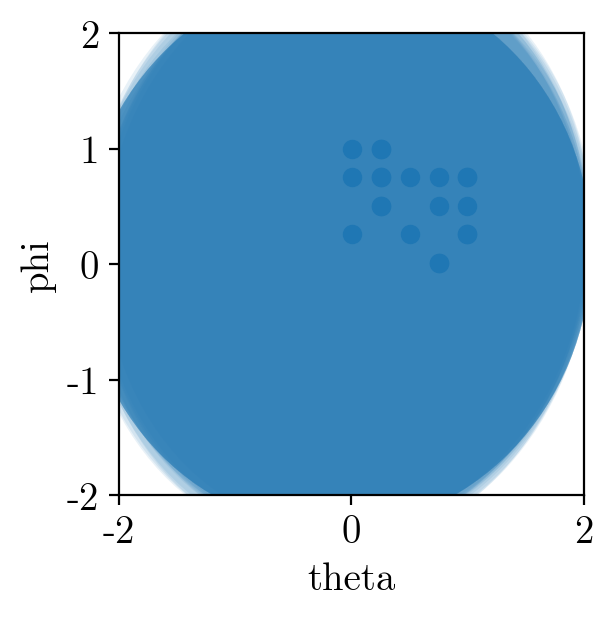

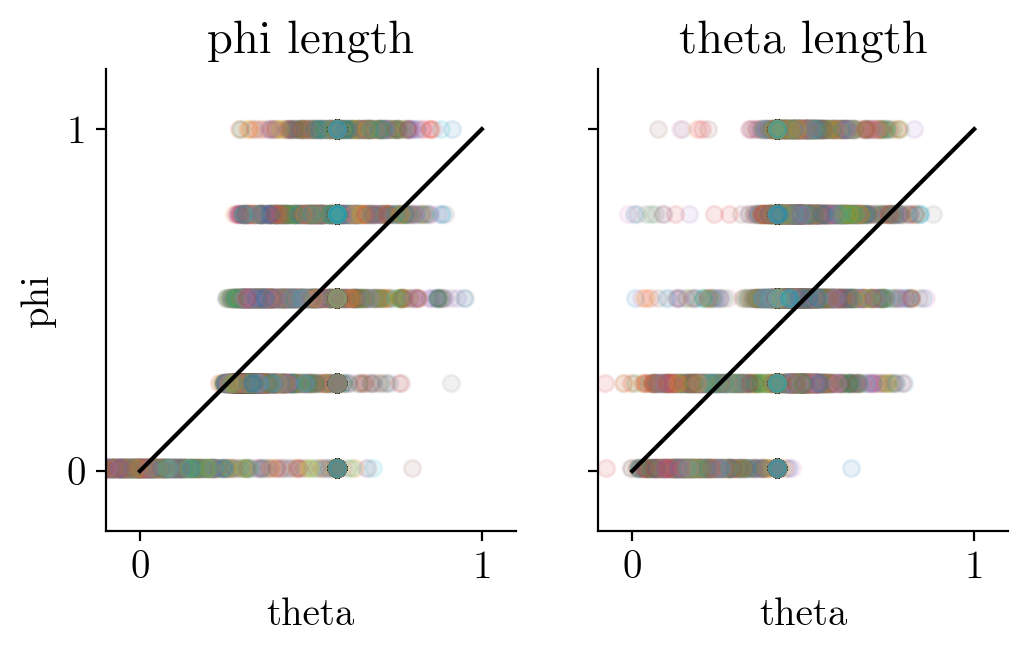

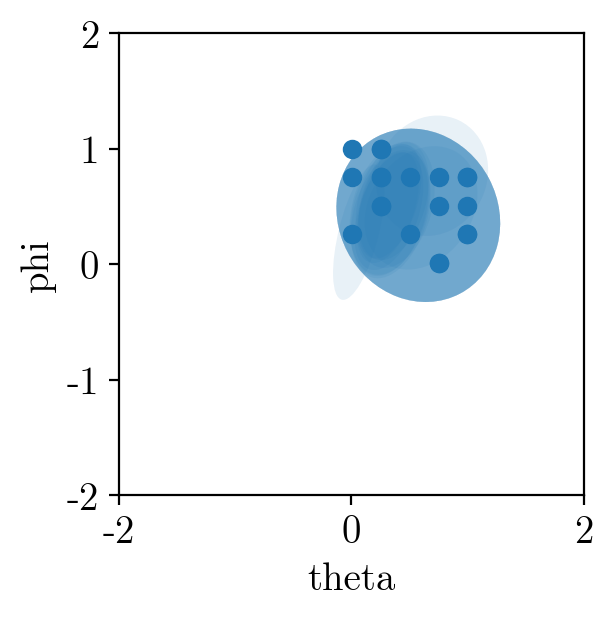

KeyboardInterrupt: 

In [1]:
import pickle
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import TensorDataset, DataLoader
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
from notification import notify
from nets.rnn import GRUNet
from numpy import pi
from plot_ult import *

datanote = 'data'
testnote='gradcliptest'
agent_name = 'ppo_baseline_0331_5cost'
with open('data/{}_{}'.format(agent_name, datanote), 'rb') as f:
    x_data, ys = pickle.load(f)
y_data = [torch.tensor(y).view(-1) for y in ys]

# x_data=x_data[:1000]
# y_data=y_data[:1000]
# use a small subset for testing
# x_data, y_data = x_data[:100], y_data[:100]

y_data = torch.stack(y_data)
y_data=y_data[:,[3,9]]
y_data=y_data/(torch.max(y_data,axis=0)[0])



# Find the maximum length of your time series data
max_length = max([len(d) for d in x_data])

# Pad your time series data with zeros at the front
x_data = [torch.tensor(x) for x in x_data]
padded_data = pad_sequence(x_data, batch_first=True, padding_value=0)
padded_data.shape  # ntrial, ts, input feature

################# normalize
# x_data[0].shape
# plt.hist(x_data[0][:,4])

# means = torch.mean(input_data, dim=0)
# stds = torch.std(input_data, dim=0)
# normalized = (input_data - means) / stds

######################

dataset = TensorDataset(padded_data)

# DataLoader from dataset
batch_size = 32
dataloader = DataLoader(dataset, batch_size=batch_size)

num_samples = len(x_data)
indices = torch.randperm(num_samples)
train_size = int(num_samples*0.9)
val_size = int(num_samples*0.9*0.1)
train_indices = indices[:train_size]
val_indices = indices[train_size-val_size:train_size]
test_indices = indices[train_size:]


train_data = torch.utils.data.TensorDataset(
    padded_data[train_indices], y_data[train_indices])
val_data = torch.utils.data.TensorDataset(
    padded_data[val_indices], y_data[val_indices])
test_data = torch.utils.data.TensorDataset(
    padded_data[test_indices], y_data[test_indices])

train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)


input_size = padded_data.shape[2]
num_layers = 2
hidden_size = 32
output_size=int(y_data[0].shape[0]+((1+y_data[0].shape[0])*y_data[0].shape[0])/2)

######################
    
def getcov(pred, ndim=2):
    predlower=pred[:,ndim:]

    predcho=[]
    for lower in predlower:
        # reshape the lower tril vector into matrix
        cho=torch.zeros(ndim,ndim)
        j=0
        for i in range(ndim):
            cho[i,:i+1]=lower[j:j+i+1]
            j+=1
            j+=i
        for i in range(ndim):
            cho[i,i+1:]=cho[i+1:,i]
        predcho.append(cho)
    predcho=torch.stack(predcho)

    cholesky_lower_triangular = torch.tril(predcho, diagonal = -1)
    cholesky_diag=torch.stack([torch.diag_embed(torch.diag(torch.exp(p))) for p in predcho])
    cholesky_sigmas =  cholesky_diag + cholesky_lower_triangular

    covariances = torch.bmm(cholesky_sigmas, torch.transpose(cholesky_sigmas, 1, 2))
    return covariances


def gaussian(mu, cov): 
    res=torch.exp(-0.5 * mu @ cov.pinverse() @ mu.T) /2 / pi /torch.sqrt(cov.det())
    return res


def likelihoodloss(pred, target, ndim=2):
    mus=pred[:,:ndim]
    predlower=pred[:,ndim:] # 10,6

    predcho=[]
    for lower in predlower:
        # reshape the lower tril vector into matrix
        cho=torch.zeros(ndim,ndim)
        j=0
        for i in range(ndim):
            cho[i,:i+1]=lower[j:j+i+1]
            j+=1
            j+=i
        for i in range(ndim):
            cho[i,i+1:]=cho[i+1:,i]
        predcho.append(cho)

    predcho=torch.stack(predcho)
    cholesky_lower_triangular = torch.tril(predcho, diagonal = -1)
    cholesky_diag=torch.stack([torch.diag_embed(torch.diag(torch.exp(p))) for p in predcho])
    cholesky_sigmas =  cholesky_diag + cholesky_lower_triangular

    p=torch.distributions.multivariate_normal.MultivariateNormal(mus,scale_tril=cholesky_sigmas)
    # genloss=-torch.mean(p.log_prob(target))
    genloss=-torch.mean(torch.clip(p.log_prob(target),-10,3))
    mseloss=torch.mean((mus-target)**2)
    res=genloss+mseloss

    return res


model = GRUNet(input_size=input_size, hidden_size=hidden_size,
               num_layers=num_layers, output_size=output_size)
criterion = likelihoodloss
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
num_epochs = 100

for epoch in range(num_epochs):
    if epoch>0:
        model.train()
        for x_batch, y_batch in train_loader:
            pred, _ = model(x_batch.float(), None)

            optimizer.zero_grad()
            loss = criterion(pred, y_batch)
            loss.backward(retain_graph=True)

            # added 0410, grad clip
            max_norm = 5.0 # Example value for maximum norm
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)

            optimizer.step()

    # eval
    model.eval()
    val_loss = 0.
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs, hidden = model(inputs.float(), None)
            val_loss += criterion(outputs, targets)
            
    notify(val_loss)

    # test
    model.eval()
    with initiate_plot(9,3,200) as fig:
        ax1=fig.add_subplot(131)
        ax2=fig.add_subplot(132)
        # ax3=fig.add_subplot(133)
        ax1.axis('equal')
        ax2.axis('equal')
        # ax3.axis('equal')
        ax1.set_xlabel('theta')
        ax1.set_ylabel('phi')
        ax2.set_xlabel('theta')
        ax2.set_ylabel('')
        # ax3.set_xlabel('theta')
        # ax3.set_ylabel('')
        ax2.set_yticklabels('')
        # ax3.set_yticklabels('')
        quickspine(ax1)
        quickspine(ax2)
        # quickspine(ax3)
        ax1.set_xticks([0,1])
        ax1.set_yticks([0,1])
        ax1.set_xlim(-0.1,1.1)
        ax1.set_ylim(-0.1,1.1)

        ax2.set_xticks([0,1])
        ax2.set_yticks([0,1])
        ax2.set_xlim(-0.1,1.1)
        ax2.set_ylim(-0.1,1.1)
        # ax3.set_xticks([0,1])
        # ax3.set_yticks([0,1])
        # ax3.set_xlim(-0.1,1.1)
        # ax3.set_ylim(-0.1,1.1)
        
        ax1.set_title('phi length')
        ax2.set_title('theta length')
        # ax3.set_title('theta cost')
        ax1.plot([0,1],[0,1],'k')
        ax2.plot([0,1],[0,1],'k')
        # ax3.plot([0,1],[0,1],'k')
        with torch.no_grad():
            for inputs, targets in test_loader:
                outputs, hidden = model(inputs.float(), None)
                ax1.scatter(outputs[:,0],targets[:,0], alpha=0.1)
                ax2.scatter(outputs[:,1],targets[:,1], alpha=0.1)
                # ax3.scatter(outputs[:,2],targets[:,2], alpha=0.1)


    with initiate_plot(3,3,200) as fig:
        ax1=fig.add_subplot(111)
        covs=getcov(outputs)
        covs=[c[:2,:2] for c in covs]
        for mu, cov in zip(outputs, covs):
            plot_cov_ellipse(cov,[mu[0], mu[1]],ax=ax1,alpha=0.1)
        ax1.scatter(targets[:,0],targets[:,1])
        ax1.set_xlabel('theta')
        ax1.set_ylabel('phi')
        ax1.set_xlim(-2,2)
        ax1.set_ylim(-2,2)



    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss_fn': criterion
    }, 'data/{}_{}_{}.pt'.format(agent_name, datanote,testnote))






